## load data & import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import kaggle

pd.set_option("display.max_rows", 200)

from mitsui_pred_challenge.utility import general_api
from mitsui_pred_challenge.utility import evaluation_api 
from mitsui_pred_challenge.kaggle_evaluation import mitsui_inference_server

In [2]:
train_df = pd.read_csv("../data/raw/train.csv")
test_df = pd.read_csv("../data/raw/test.csv")
train_labels_df = pd.read_csv("../data/raw/train_labels.csv")
target_pairs_df = pd.read_csv("../data/raw/target_pairs.csv")  

## General data description

### Overview columns and general structure

In [3]:
train_df.info(show_counts=True, max_cols = 600, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 558 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    date_id                                         1917 non-null   int64  
 1    LME_AH_Close                                    1867 non-null   float64
 2    LME_CA_Close                                    1867 non-null   float64
 3    LME_PB_Close                                    1867 non-null   float64
 4    LME_ZS_Close                                    1867 non-null   float64
 5    JPX_Gold_Mini_Futures_Open                      1802 non-null   float64
 6    JPX_Gold_Rolling-Spot_Futures_Open              1802 non-null   float64
 7    JPX_Gold_Standard_Futures_Open                  1802 non-null   float64
 8    JPX_Platinum_Mini_Futures_Open                  1802 non-null   float64
 9    JPX_Platinum_Standard_Future

In [4]:
test_df.info(show_counts=True, max_cols = 600, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 559 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    date_id                                         90 non-null     int64  
 1    LME_AH_Close                                    88 non-null     float64
 2    LME_CA_Close                                    88 non-null     float64
 3    LME_PB_Close                                    88 non-null     float64
 4    LME_ZS_Close                                    88 non-null     float64
 5    JPX_Gold_Mini_Futures_Open                      85 non-null     float64
 6    JPX_Gold_Rolling-Spot_Futures_Open              85 non-null     float64
 7    JPX_Gold_Standard_Futures_Open                  85 non-null     float64
 8    JPX_Platinum_Mini_Futures_Open                  85 non-null     float64
 9    JPX_Platinum_Standard_Futures_Op

In [5]:
train_labels_df.info(show_counts=True, max_cols = 600, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 425 columns):
 #    Column      Non-Null Count  Dtype  
---   ------      --------------  -----  
 0    date_id     1917 non-null   int64  
 1    target_0    1787 non-null   float64
 2    target_1    1744 non-null   float64
 3    target_2    1831 non-null   float64
 4    target_3    1831 non-null   float64
 5    target_4    1631 non-null   float64
 6    target_5    1631 non-null   float64
 7    target_6    1831 non-null   float64
 8    target_7    1744 non-null   float64
 9    target_8    1587 non-null   float64
 10   target_9    1831 non-null   float64
 11   target_10   1587 non-null   float64
 12   target_11   1831 non-null   float64
 13   target_12   1712 non-null   float64
 14   target_13   1831 non-null   float64
 15   target_14   1712 non-null   float64
 16   target_15   1831 non-null   float64
 17   target_16   1744 non-null   float64
 18   target_17   1587 non-null   float64
 19   targ

In [6]:
target_pairs_df.info(show_counts=True, max_cols = 600, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  424 non-null    object
 1   lag     424 non-null    int64 
 2   pair    424 non-null    object
dtypes: int64(1), object(2)
memory usage: 71.0 KB


### Inspect time dimension

In [7]:
train_df["date_id"].min(), train_df["date_id"].max()

(np.int64(0), np.int64(1916))

In [8]:
test_df["date_id"].min(), test_df["date_id"].max()

(np.int64(1827), np.int64(1916))

--> The test_df is a slice of the train_df

---

### Inspect the target

The target is structured as follows:
* in "train_labels_df" the targets are columnwise listed with their respective log return (explaination below) 
* The "target_pairs_df" is a mapping table to assign the respective columns of "train_labels_df" to the correct asset / asset_difference 

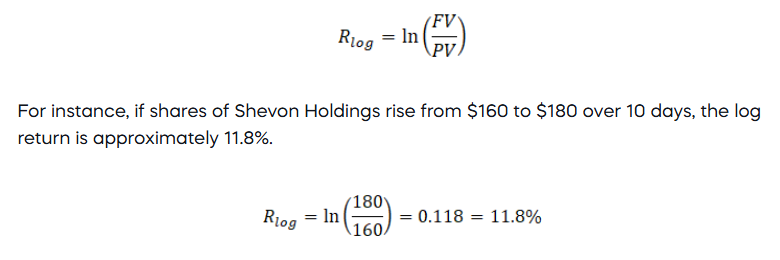

In [9]:
train_labels_df

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0,0.005948,-0.002851,-0.004675,-0.000639,NaN,NaN,-0.006729,0.006066,NaN,...,NaN,0.021239,-0.005595,NaN,-0.004628,0.033793,NaN,0.038234,NaN,0.027310
1,1,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.003377,0.021372,-0.001517,0.012846,0.010547,0.030527,-0.000764,0.025021,0.003548,0.020940
2,2,0.001048,0.023836,-0.008934,-0.022060,NaN,NaN,0.037449,0.007658,NaN,...,-0.006712,0.009308,0.001857,-0.012761,-0.002345,0.017529,-0.005394,0.004835,-0.009075,0.001706
3,3,0.001700,-0.024618,0.011943,0.004778,NaN,NaN,-0.012519,-0.016896,NaN,...,NaN,0.036880,-0.015189,NaN,0.008118,0.001079,NaN,-0.015102,NaN,-0.033010
4,4,-0.003272,0.005234,0.006856,0.013312,0.023953,0.010681,-0.011649,0.002019,0.003897,...,NaN,0.004937,NaN,-0.006673,-0.016105,-0.004885,NaN,NaN,0.009514,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,1912,-0.012596,0.009309,0.007947,0.006477,-0.026216,-0.029487,-0.003287,0.011751,-0.027610,...,NaN,NaN,NaN,0.042052,NaN,NaN,NaN,NaN,0.031006,NaN
1913,1913,-0.000736,-0.001292,-0.005137,-0.007961,-0.008494,-0.011547,0.004263,0.005670,-0.004822,...,-0.012992,-0.003349,0.010912,0.006198,-0.009216,-0.003038,-0.026082,-0.008057,-0.002069,-0.141053
1914,1914,-0.002294,0.012898,0.009978,0.001567,0.002596,-0.007373,0.007554,0.002661,0.004083,...,-0.005240,0.004044,0.004459,0.002619,0.001308,-0.006772,-0.019918,-0.013304,-0.005527,-0.127688
1915,1915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.008250,0.012842,0.009076,0.000932,0.011613,0.003825,0.024350,-0.006928,0.006805,-0.012187


In [10]:
target_pairs_df

,target,lag,pair
0,target_0,1,US_Stock_VT_adj_close
1,target_1,1,LME_PB_Close - US_Stock_VT_adj_close
2,target_2,1,LME_CA_Close - LME_ZS_Close
3,target_3,1,LME_AH_Close - LME_ZS_Close
4,target_4,1,LME_AH_Close - JPX_Gold_Standard_Futures_Close
...,...,...,...
419,target_419,4,FX_NOKUSD - LME_AH_Close
420,target_420,4,JPX_Gold_Standard_Futures_Close - US_Stock_RY_...
421,target_421,4,US_Stock_EWT_adj_close - LME_AH_Close
422,target_422,4,JPX_Platinum_Standard_Futures_Close - FX_NOKCHF


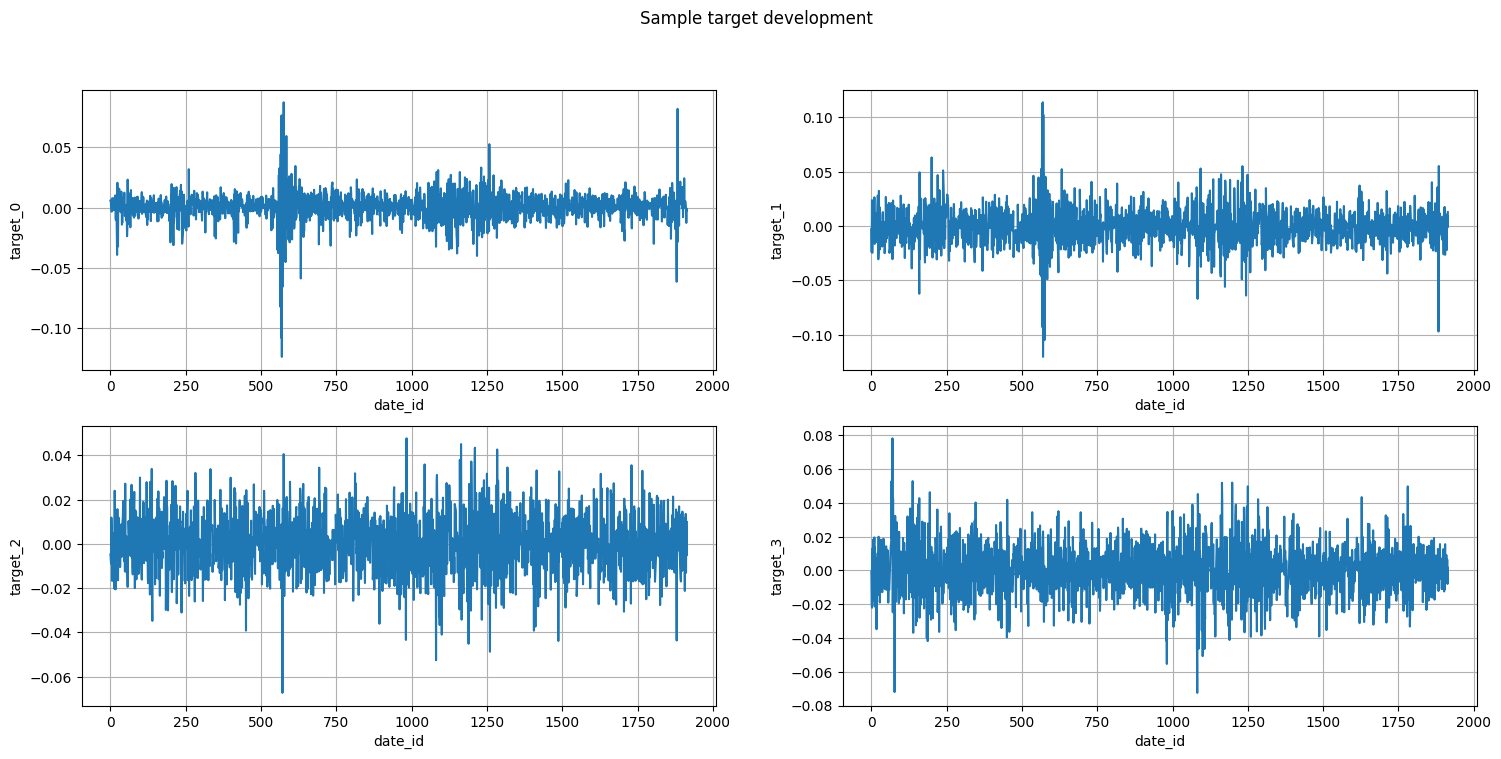

In [11]:
cols = ["date_id" ,"target_0", "target_1", "target_2", "target_3"]

fig, sub = plt.subplots(2,2, figsize = (18,8))
subs = sub.flatten()

for i, col in enumerate(cols[1:]):

    sns.lineplot(x = train_labels_df[cols]["date_id"], y = train_labels_df[cols][col], ax = subs[i])
    subs[i].grid()

fig.suptitle("Sample target development");

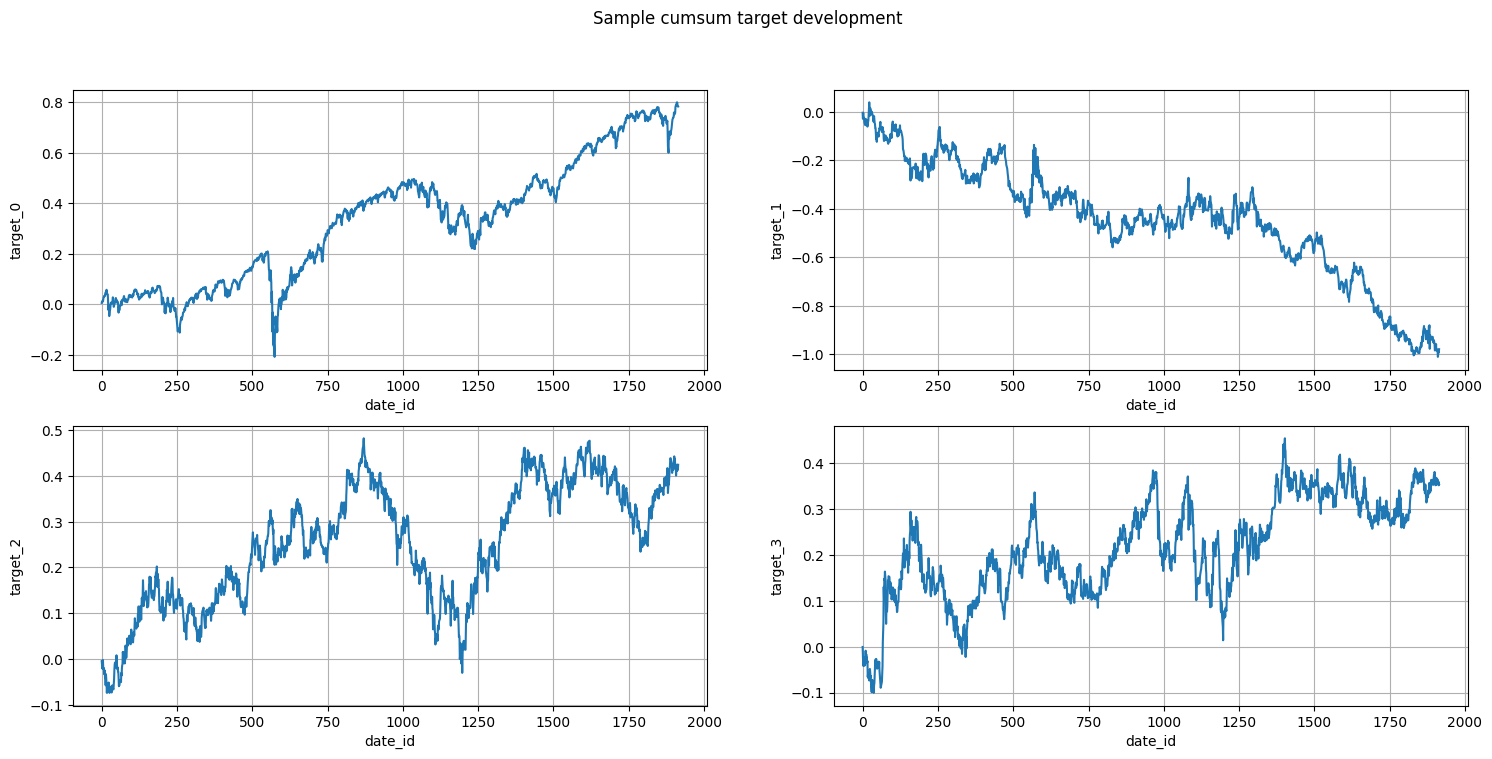

In [12]:
cols = ["date_id" ,"target_0", "target_1", "target_2", "target_3"]

fig, sub = plt.subplots(2,2, figsize = (18,8))
subs = sub.flatten()

for i, col in enumerate(cols[1:]):

    sns.lineplot(x = train_labels_df[cols]["date_id"], y = train_labels_df[cols][col].cumsum(), ax = subs[i])
    subs[i].grid()

fig.suptitle("Sample cumsum target development");

## Understand the target calculation

### y_target

In [13]:
y_target = train_labels_df[train_labels_df["date_id"].isin(test_df["date_id"])]
y_target.head()

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
1827,1827,NaN,NaN,0.017868,-0.000205,-0.016391,-0.013827,0.009972,NaN,NaN,...,NaN,0.019701,NaN,-0.027030,0.043602,0.027982,NaN,NaN,0.002177,NaN
1828,1828,0.002560,-0.004592,-0.001776,0.000271,-0.016696,-0.020025,0.002514,0.002204,-0.011962,...,0.012063,0.012081,-0.020068,0.002858,0.019154,0.019018,0.003875,-0.035202,0.011246,0.099241
1829,1829,0.005346,-0.014539,0.019542,0.014626,-0.011631,-0.009223,-0.005199,-0.026092,-0.003865,...,-0.009004,0.016166,-0.028919,-0.007297,0.033262,0.023174,-0.028512,-0.017900,-0.002096,0.121451
1830,1830,0.000082,-0.005226,0.011452,0.013346,0.008228,-0.014819,-0.011792,-0.007148,0.005712,...,-0.013857,-0.007742,-0.018436,0.004691,0.013311,0.000589,-0.014500,-0.046444,0.009058,0.109246
1831,1831,-0.011469,0.016613,-0.023765,-0.018744,-0.011878,0.007257,0.019829,0.006618,-0.015351,...,-0.015625,-0.018850,-0.025373,0.031197,0.005873,-0.005650,-0.022926,-0.027990,0.011267,0.091318


In [14]:
y_pred_preparation = train_df[train_df["date_id"].isin(test_df["date_id"])]
y_pred_preparation.head()

,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,FX_GBPCAD,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP
1827,1827,2684.5,9190.0,1967.0,2942.0,13623.0,13920.0,13618.0,4696.0,4692.0,...,1.763116,0.631633,0.808485,0.510666,0.051733,0.071654,0.079797,0.048828,13.631347,0.043845
1828,1828,2691.5,9275.0,1985.0,2963.5,13640.0,13922.0,13634.0,4613.0,4613.0,...,1.763604,0.633526,0.812571,0.514785,0.051802,0.071793,0.080214,0.048912,13.743387,0.043778
1829,1829,2646.0,9284.5,1971.0,2914.0,13634.0,13923.0,13638.0,4647.0,4632.0,...,1.769694,0.632156,0.811948,0.513278,0.051902,0.071630,0.080134,0.048971,13.766241,0.043774
1830,1830,2634.0,9223.5,1967.0,2900.0,13681.5,13962.0,13680.0,4630.0,4631.0,...,1.772475,0.629661,0.815155,0.513271,0.051907,0.071972,0.080325,0.048968,13.864629,0.043876
1831,1831,2623.5,9232.0,1949.0,2846.5,13849.5,14141.0,13844.0,4699.5,4703.0,...,1.776607,0.630969,0.816284,0.515051,0.051867,0.071790,0.080475,0.049027,13.847691,0.043736


### Lag 1 Calc.

In [15]:
example_pairs = general_api.prepare_target_pairs(target_pairs_df)["lag_1"].head()
example_pairs

,target,asset_1,asset_2
0,target_0,US_Stock_VT_adj_close,NaN
1,target_1,LME_PB_Close,US_Stock_VT_adj_close
2,target_2,LME_CA_Close,LME_ZS_Close
3,target_3,LME_AH_Close,LME_ZS_Close
4,target_4,LME_AH_Close,JPX_Gold_Standard_Futures_Close


In [16]:
test_data = train_df[train_df["date_id"].isin(test_df["date_id"])]

In [17]:
target_0_assets = example_pairs[example_pairs["target"] == "target_0"][["asset_1", "asset_2"]]
target_1_assets = example_pairs[example_pairs["target"] == "target_1"][["asset_1", "asset_2"]]

target_0_assets_ls = [element for element in target_0_assets.values[0] if pd.notna(element)]
target_1_assets_ls = [element for element in target_1_assets.values[0] if pd.notna(element)]

y_target_0 = y_target[["date_id", "target_0"]].copy()
y_target_1 = y_target[["date_id", "target_1"]].copy()

In [18]:
#Target 0 
target_0_lr = general_api.calculate_log_return(test_data, target_0_assets_ls, lag = 1)

#Target 1
target_1_lr = general_api.calculate_log_return(test_data, target_1_assets_ls, lag = 1)

In [19]:
target_0_lr = pd.merge(left = y_target_0, right = target_0_lr, left_on="date_id", right_on = "date_id")
target_1_lr = pd.merge(left = y_target_1, right = target_1_lr, left_on="date_id", right_on = "date_id")

In [20]:
target_0_lr.head()

,date_id,target_0,log_return
0,1827,NaN,NaN
1,1828,0.002560,0.002560
2,1829,0.005346,0.005346
3,1830,0.000082,0.000082
4,1831,-0.011469,-0.011469


In [21]:
target_1_lr.head()

,date_id,target_1,log_return
0,1827,NaN,NaN
1,1828,-0.004592,-0.004592
2,1829,-0.014539,-0.014539
3,1830,-0.005226,-0.005226
4,1831,0.016613,0.016613


### Lag 2 Calc.

In [22]:
example_pairs = general_api.prepare_target_pairs(target_pairs_df)["lag_2"].head()
example_pairs

,target,asset_1,asset_2
106,target_106,US_Stock_VXUS_adj_close,NaN
107,target_107,LME_ZS_Close,US_Stock_VXUS_adj_close
108,target_108,LME_ZS_Close,LME_PB_Close
109,target_109,LME_AH_Close,JPX_Gold_Standard_Futures_Close
110,target_110,JPX_Platinum_Standard_Futures_Close,LME_AH_Close


In [23]:
target_106_assets = example_pairs[example_pairs["target"] == "target_106"][["asset_1", "asset_2"]]
target_107_assets = example_pairs[example_pairs["target"] == "target_107"][["asset_1", "asset_2"]]

target_106_assets_ls = [element for element in target_106_assets.values[0] if pd.notna(element)]
target_107_assets_ls = [element for element in target_107_assets.values[0] if pd.notna(element)]

y_target_106 = y_target[["date_id", "target_106"]].copy()
y_target_107 = y_target[["date_id", "target_107"]].copy()

In [24]:
#Target 106 
target_106_lr = general_api.calculate_log_return(test_data, target_106_assets_ls, lag = 2)

#Target 107
target_107_lr = general_api.calculate_log_return(test_data, target_107_assets_ls, lag = 2)

In [25]:
target_106_lr = pd.merge(left = y_target_106, right = target_106_lr, left_on="date_id", right_on = "date_id")
target_107_lr = pd.merge(left = y_target_107, right = target_107_lr, left_on="date_id", right_on = "date_id")

In [26]:
target_106_lr.head()

,date_id,target_106,log_return
0,1827,NaN,NaN
1,1828,0.004287,0.004287
2,1829,0.011360,0.011360
3,1830,-0.000987,-0.000987
4,1831,-0.004759,-0.004759


In [27]:
target_106_lr.head()

,date_id,target_106,log_return
0,1827,NaN,NaN
1,1828,0.004287,0.004287
2,1829,0.011360,0.011360
3,1830,-0.000987,-0.000987
4,1831,-0.004759,-0.004759


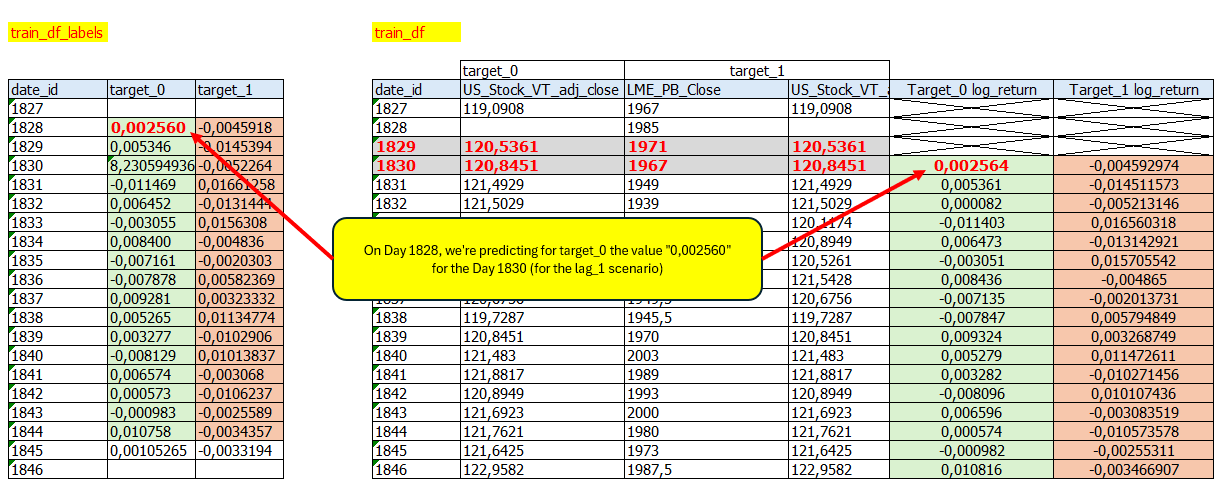

As stated above the target value should be predicted at $(t_{realization-of-log-return} - lag - 1)$. (Note: There are some rounding differences)<br>
Hence, at date_id = 1835 in the lag=1 scenario, we are predicting the log-return of date_id = 1837

In [28]:
complete_train_df = pd.merge(
    left = train_df
    ,right = train_labels_df
    ,left_on = "date_id"
    ,right_on = "date_id"
    ,how = "inner"
)

complete_train_df.head()

,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0,2264.5,7205.0,2570.0,3349.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.021239,-0.005595,NaN,-0.004628,0.033793,NaN,0.038234,NaN,0.027310
1,1,2228.0,7147.0,2579.0,3327.0,NaN,NaN,NaN,NaN,NaN,...,0.003377,0.021372,-0.001517,0.012846,0.010547,0.030527,-0.000764,0.025021,0.003548,0.020940
2,2,2250.0,7188.5,2587.0,3362.0,4684.0,4691.0,4684.0,3363.0,3367.0,...,-0.006712,0.009308,0.001857,-0.012761,-0.002345,0.017529,-0.005394,0.004835,-0.009075,0.001706
3,3,2202.5,7121.0,2540.0,3354.0,4728.0,4737.0,4729.0,3430.0,3426.0,...,NaN,0.036880,-0.015189,NaN,0.008118,0.001079,NaN,-0.015102,NaN,-0.033010
4,4,2175.0,7125.0,2604.0,3386.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.004937,NaN,-0.006673,-0.016105,-0.004885,NaN,NaN,0.009514,NaN


In [29]:
prepared_target_values = general_api.prepare_target_data(target_pairs_df=target_pairs_df, train_df=train_df)

In [30]:
prepared_target_df = prepared_target_values["lag_1"].copy()

for lag_ in ["lag_2", "lag_3", "lag_4"]:

    prepared_target_df = pd.merge(
        left = prepared_target_df,
        right = prepared_target_values[lag_].copy(),
        left_on = "date_id",
        right_on= "date_id",
        how = "left"
    )

In [31]:
(prepared_target_df[prepared_target_df["date_id"].isin(y_target["date_id"])] - y_target).sum().sort_values(ascending=False)

target_342    2.254720e-15
target_405    2.085571e-15
target_419    2.015532e-15
target_330    1.604414e-15
target_206    1.602966e-15
                  ...     
target_8     -1.573448e-15
target_401   -1.647987e-15
target_244   -1.756950e-15
target_237   -1.767304e-15
target_340   -1.852224e-15
Length: 425, dtype: float64

## Evaluation Metric

https://www.kaggle.com/code/metric/mitsui-co-commodity-prediction-metric <br>
https://en.wikipedia.org/wiki/Sharpe_ratio

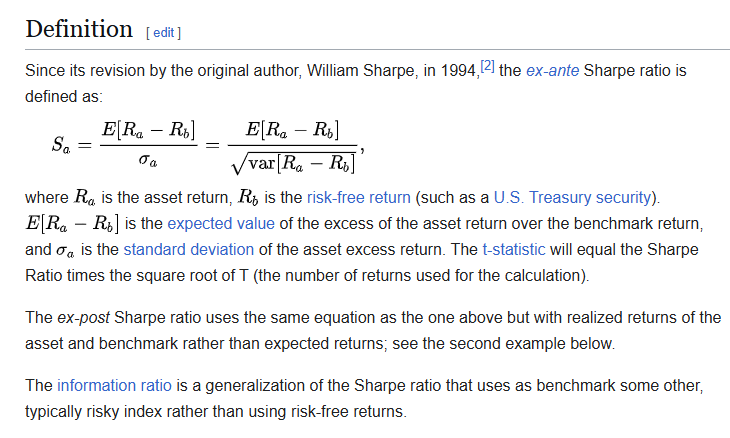

In [32]:
train_labels_df_sub = train_labels_df.copy()
train_labels_df_sub.columns = [re.sub("target_","prediction_",col) for col in train_labels_df_sub.columns]

In [33]:
merged_df = pd.merge(left = train_labels_df, right=train_labels_df_sub, left_on = "date_id", right_on="date_id", how = "inner")

In [34]:
evaluation_api.rank_correlation_sharpe_ratio(merged_df)

1.114547705657013e+16

## Submission

In [37]:
"""
The evaluation API requires that you set up a server which will respond to inference requests.
We have already defined the server; you just need write the predict function.
When we evaluate your submission on the hidden test set the client defined in `mitsui_gateway` will run in a different container
with direct access to the hidden test set and hand off the data timestep by timestep.

Your code will always have access to the published copies of the competition files.
"""

import os

import pandas as pd
import polars as pl

import mitsui_inference_server

#-----------------------
NUM_TARGET_COLUMNS = 424


def predict(
    test: pl.DataFrame,
    label_lags_1_batch: pl.DataFrame,
    label_lags_2_batch: pl.DataFrame,
    label_lags_3_batch: pl.DataFrame,
    label_lags_4_batch: pl.DataFrame,
) -> pl.DataFrame | pd.DataFrame:
    """Replace this function with your inference code.
    You can return either a Pandas or Polars dataframe, though Polars is recommended for performance.
    Each batch of predictions (except the very first) must be returned within 1 minute of the batch features being provided.
    """
    predictions = pl.DataFrame({f'target_{i}': i / 1000 for i in range(NUM_TARGET_COLUMNS)})

    assert isinstance(predictions, (pd.DataFrame, pl.DataFrame))
    assert len(predictions) == 1
    return predictions


# When your notebook is run on the hidden test set, inference_server.serve must be called within 15 minutes of the notebook starting
# or the gateway will throw an error. If you need more than 15 minutes to load your model you can do so during the very
# first `predict` call, which does not have the usual 1 minute response deadline.
inference_server = mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
# else:
#     inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))